# Crosslingual results

Currently the results are for StoryCloze

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

from examples.few_shot.scripts.collect_results import load_results, print_json_structure, filter_by, get_first_pred_prompts_example

# prediction_gold_scores_hard: List[List[float]] = get_predictions_gold_probability_for_results_file(results_file, soft_scores=False, ensemble=True)

In [2]:
import os
import pprint
import pandas as pd
from pandas import DataFrame
import sys

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import logging
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
cmap_green_yellow_red = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['green','yellow','red']
)
import matplotlib
matplotlib._log.disabled = True
logging.basicConfig(level='CRITICAL')
# Turn off sina logging
for name in [
             "matplotlib", "matplotlib.font", "matplotlib.pyplot"]:
    logger = logging.getLogger(name)
    logger.setLevel(logging.CRITICAL)
    logger.disabled = True
    
from scipy.stats import bootstrap

import numpy as np
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))



pd.Series.filter_by = filter_by
pd.DataFrame.filter_by = filter_by

DEBUG - matplotlib data path: /private/home/tbmihaylov/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG - CONFIGDIR=/private/home/tbmihaylov/.config/matplotlib
DEBUG - matplotlib version 3.4.2
DEBUG - interactive is False
DEBUG - platform is linux
DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'functools',

DEBUG - CACHEDIR=/private/home/tbmihaylov/.cache/matplotlib
DEBUG - Using fontManager instance from /private/home/tbmihaylov/.cache/matplotlib/fontlist-v330.json
DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Loading our data 

In [3]:
# list(results[0].keys())

In [4]:
# Load our results

results_raw_jsonl_list = ["/large_experiments/xlmg/results/multilingual/dense_7.5B_crosslingual/results.tsv.raw.jsonl"]

#results_raw_jsonl_list = ["/large_experiments/xlmg/results/multilingual/dense_7_5B_30lang_cpts/results.tsv.raw.jsonl"]
all_results = []
for results_raw_file in results_raw_jsonl_list:
    results, expanded_results, current_tasks_to_groups  = load_results(results_raw_file)
    all_results.extend(results)

results = all_results
print(f"{len(results)} loaded")

121 loaded


In [5]:
debug_prompts = True

if debug_prompts:
    max_print = 5
    print_id = 0
    for res in results:
        #if res["train_lang"] == "ru" and res["language"] == "en":
        res_file = res["results_file"]
        print(get_first_pred_prompts_example(res_file))
        print_id += 1
        if print_id >= max_print:
            break
        

### Prompt for cand `Bob told the man to leave him alone.`:
Derek is tired of living at home with his parents. One day, his friend suggested they move in together. He told his parents. That night, they packed his stuff. Derek was happy to finally be out.
My chest hair was getting out of control. I decided I needed to take some trimmers to it. I stepped into the shower and started to shave it off. The hair started to plug the drain because there was so much. I decided to get it waxed.
My cousin's had a terrible experience with their babysitter. They had a hidden camera. They found video of her shaking the baby violently. The baby is having major problems. They reported the babysitter to the police.
When I first moved into my house, I didn't know my neighbors. While mowing one day, I found a kickball in my yard. I felt this was the perfect opportunity to meet my neighbors. I grabbed the ball and went next door to return it. They were very friendly.
The old dog was doing worse than usual.

# Process results
Filter some columns for faster processing

In [6]:
# Group by the unique keys

df = pd.DataFrame.from_records(results)

# these are the fields that we want to group by
index_cols = ["task", 
              "language",
              "eval_examples_cnt",
              "eval_set", 
              "train_set", 
              "train_lang",
              "nb_few_shot_samples", 
              "calibration",
              "template",
              "model_name", # we need the results file to load the predictions
             ]
value_cols_all = ["_metric_val",
                  "_metric_val_std",
              #"results_file"
                 ]  # this is only the preferred value
value_cols = [x for x in value_cols_all if x in df.columns]
cols = []

df_selected = df[index_cols + value_cols + cols]

# debug - group by
# pt = pd.pivot_table(df_selected, values=value_cols, index=index_cols,
#                    columns=cols, aggfunc=[np.mean])
# pt = pt.swaplevel(1, 2, axis=1).sort_index(axis=1)
# pt

df_selected = df_selected.set_index(index_cols)  # this is for easy filtering
df_selected


_metric_val  \
task       language eval_examples_cnt eval_set                 train_set                 train_lang nb_few_shot_samples calibration template   model_name                                                        
storycloze en       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    76.715232   
                                                                                         id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    74.225166   
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    68.794702   
           zh       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    65.443709   
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    69.642384   
...                                                                                                                                                                                                        ...   
           te       1510              val2016_split_20_80_eval val2016_split_20_80_train sw         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    60.649007   
                                                                                         eu         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    60.119205   
           hi       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    59.682119   
           ar       1510              val2016_split_20_80_eval val2016_split_20_80_train ru         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    57.218543   
           te       1510              val2016_split_20_80_eval val2016_split_20_80_train te         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    64.000000   

                                                                                                                                                                                                   _metric_val_std  
task       language eval_examples_cnt eval_set                 train_set                 train_lang nb_few_shot_samples calibration template   model_name                                                           
storycloze en       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.253392  
                                                                                         id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.322809  
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.227105  
           zh       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.442075  
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__ste

# Filter data 
Filter here to improve the performance.
We will do pairwise comparisons below!  

In [7]:

filter_json = {
    'task': ["storycloze"], 
    'language': None, # ["en"], 
    'eval_examples_cnt': None, 
    'eval_set': ["val2016_split_20_80_eval"],  # ["val2016"]
    'train_set': None,
    'train_lang': None, 
    'nb_few_shot_samples': None, 
    'calibration': None, 
    'template': None,
    'model_name': ["dense_7.5B_lang30_new_cc100_xl_unigram__step00238000"]
}



df_filtered = df_selected.filter_by(
    filter_json
)
# df_filtered.to_csv("results_debug.tsv")
df_filtered

_metric_val  \
task       language eval_examples_cnt eval_set                 train_set                 train_lang nb_few_shot_samples calibration template   model_name                                                        
storycloze en       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    76.715232   
                                                                                         id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    74.225166   
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    68.794702   
           zh       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    65.443709   
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    69.642384   
...                                                                                                                                                                                                        ...   
           te       1510              val2016_split_20_80_eval val2016_split_20_80_train sw         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    60.649007   
                                                                                         eu         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    60.119205   
           hi       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    59.682119   
           ar       1510              val2016_split_20_80_eval val2016_split_20_80_train ru         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    57.218543   
           te       1510              val2016_split_20_80_eval val2016_split_20_80_train te         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    64.000000   

                                                                                                                                                                                                   _metric_val_std  
task       language eval_examples_cnt eval_set                 train_set                 train_lang nb_few_shot_samples calibration template   model_name                                                           
storycloze en       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.253392  
                                                                                         id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.322809  
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train id         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.227105  
           zh       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.442075  
           ru       1510              val2016_split_20_80_eval val2016_split_20_80_train en         32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__ste

In [8]:
pt = pd.pivot_table(df_filtered, values=["_metric_val"], #value_cols, 
                    index=["train_lang"],
                    columns=["language"], aggfunc=[np.mean])
#pt = pt.swaplevel(1, 2, axis=1).sort_index(axis=1)
pt

mean                                                         \
           _metric_val                                                          
language            ar         en         es         eu         hi         id   
train_lang                                                                      
ar           60.158940  73.682119  66.993377  59.854305  58.596026  67.218543   
en           57.178808  76.715232  66.251656  60.410596  59.682119  68.331126   
es           57.165563  73.827815  69.509934  60.635762  57.403974  67.271523   
eu           57.284768  72.622517  66.569536  63.390728  58.264901  65.284768   
hi           57.350993  74.092715  67.470199  60.092715  63.178808  67.509934   
id           56.264901  74.225166  66.437086  58.900662  58.860927  71.205298   
my           57.920530  72.927152  66.768212  59.721854  58.437086  67.470199   
ru           57.218543  74.847682  66.940397  59.629139  59.046358  67.907285   
sw           56.754967  73.125828  65.761589  58.370861  57.933775  66.662252   
te           56.927152  73.880795  68.357616  59.576159  59.324503  67.721854   
zh           57.576159  74.026490  66.317881  58.741722  58.807947  66.569536   

                                                                   
                                                                   
language           my         ru         sw         te         zh  
train_lang                                                         
ar          57.986755  68.807947  61.337748  61.509934  64.993377  
en          59.615894  69.642384  63.403974  60.993377  65.443709  
es          58.701987  69.218543  62.026490  60.423841  64.768212  
eu          57.589404  68.503311  60.079470  60.119205  64.794702  
hi          58.821192  70.000000  61.774834  62.649007  65.403974  
id          58.437086  68.794702  61.430464  60.410596  64.688742  
my          61.099338  68.900662  61.774834  62.357616  65.788079  
ru          58.887417  72.741722  61.324503  61.139073  66.264901  
sw          58.701987  69.178808  65.801325  60.649007  64.622517  
te          57.298013  70.198675  61.973510  64.000000  65.456954  
zh          58.516556  68.622517  61.139073  61.417219  67.973510

In [9]:
results_matrix = pt.to_numpy()
results_matrix.diagonal()

array([60.1589404 , 76.71523179, 69.50993377, 63.39072848, 63.17880795,
       71.20529801, 61.09933775, 72.74172185, 65.8013245 , 64.        ,
       67.97350993])

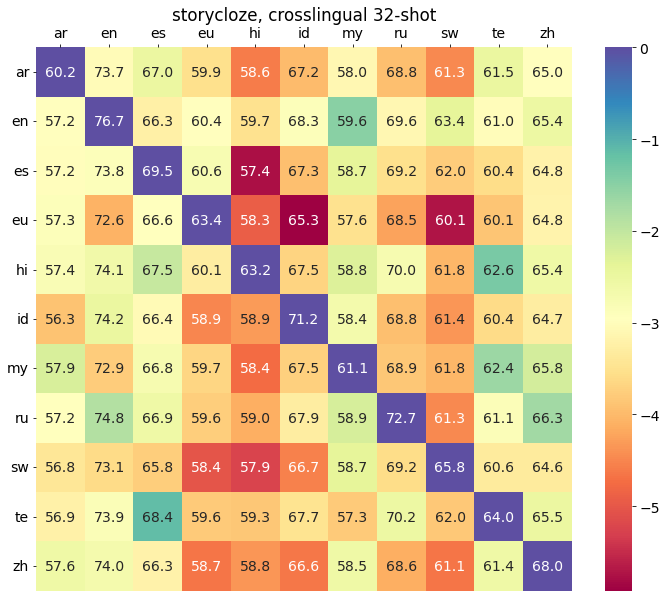

In [10]:
matplotlib.pyplot.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.facecolor']='white'
results_matrix = pt.to_numpy()
results_matrix_orig = pt.to_numpy()
results_matrix = results_matrix - results_matrix.diagonal()

model_labels_x_axis = list(pt.index)
model_labels_y_axis = model_labels_x_axis

ax = sns.heatmap(results_matrix, 
            mask=None, 
            xticklabels=model_labels_x_axis,
            yticklabels=model_labels_y_axis,
            vmin=results_matrix.min(),
            vmax=results_matrix.max(),
            annot=results_matrix_orig,
            cmap=sns.color_palette("Spectral", as_cmap=True),
            fmt='.1f')
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title("storycloze, crosslingual 32-shot")

plt.show()